<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Car_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[Car Object Detection](https://www.kaggle.com/datasets/sshikamaru/car-object-detection/code?datasetId=843852&sortBy=voteCount)

## Refference
  1 [SERHANAYBERKKILIC, "car_detection_rcnn_acc%97", "https://www.kaggle.com/code/serhanayberkkl/car-detection-rcnn-acc-97", 2021](https://www.kaggle.com/code/serhanayberkkl/car-detection-rcnn-acc-97)  
  2 [Google ColabでGPU対応OpenCVをインストール](https://an-engineer-note.com/?p=570)

## 0. Setting for Google Colab

In [ ]:
!git clone https://github.com/opencv/opencv
!git clone https://github.com/opencv/opencv_contrib
!mkdir /content/build
%cd /content/build
!cmake -DOPENCV_EXTRA_MODULES_PATH=/content/opencv_contrib/modules  -DBUILD_SHARED_LIBS=OFF  -DBUILD_TESTS=OFF  -DBUILD_PERF_TESTS=OFF -DBUILD_EXAMPLES=OFF -DWITH_OPENEXR=OFF -DWITH_CUDA=ON -DWITH_CUBLAS=ON -DWITH_CUDNN=ON -DOPENCV_DNN_CUDA=ON /content/opencv
!make -j8 install

Cloning into 'opencv'...
remote: Enumerating objects: 333005, done.
remote: Counting objects: 100% (488/488), done.
remote: Compressing objects: 100% (393/393), done.
remote: Total 333005 (delta 174), reused 274 (delta 81), pack-reused 332517
Receiving objects: 100% (333005/333005), 523.48 MiB | 17.36 MiB/s, done.
Resolving deltas: 100% (232188/232188), done.
Updating files: 100% (7510/7510), done.
Cloning into 'opencv_contrib'...
remote: Enumerating objects: 41328, done.
remote: Counting objects: 100% (1095/1095), done.
remote: Compressing objects: 100% (775/775), done.
remote: Total 41328 (delta 375), reused 801 (delta 256), pack-reused 40233
Receiving objects: 100% (41328/41328), 149.85 MiB | 30.66 MiB/s, done.
Resolving deltas: 100% (25479/25479), done.
/content/build
-- 'Release' build type is used by default. Use CMAKE_BUILD_TYPE to specify build type (Release or Debug)
-- The CXX compiler identification is GNU 11.4.0
-- The C compiler identification is GNU 11.4.0
-- Detecting CX

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir  "/content/drive/My Drive/cv2_cuda"
!cp  /content/build/lib/python3/cv2.cpython-36m-x86_64-linux-gnu.so /content/drive/My Drive/cv2_cuda/cv2.so

In [ ]:
# ランタイムが初期化されたり新規でNotebookを立ち上げて作業する場合、こんな感じで読み込む（Google Driveはマウント済みであること）
!cp /content/drive/My Drive/cv2_cuda/cv2.so/content/

In [ ]:
import cv2
print(cv2.cuda.getCudaEnabledDeviceCount())

In [2]:
INPUT_DIR:str = "/content/drive/MyDrive/Car_Object_Detection/01_input"
ANALYSIS_DIR:str = "/content/drive/MyDrive/Car_Object_Detection/03_code-analysis"
MODEL_DIR:str = "/content/drive/MyDrive/Car_Object_Detection//04_model"
SUBMISSION_DIR:str = '/content/drive/MyDrive/Car_Object_Detection/05_submission'
CHECKPOINT_PATH:str = MODEL_DIR

In [3]:
import os, gc, glob, shutil, zipfile

shutil.unpack_archive(INPUT_DIR+'/training_images.zip', './')
shutil.unpack_archive(INPUT_DIR+'/testing_images.zip', './')

## 1. Importing Modules

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random

## 2. Data Loading

In [5]:
print('Image(Train):',len(os.listdir('./training_images')))
print('Image(Test):',len(os.listdir('./testing_images')))

Image(Train): 1001
Image(Test): 175


In [6]:
df = pd.read_csv(INPUT_DIR+'/train_solution_bounding_boxes.csv')
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [7]:
print('Train data localization:',len(df))

Train data localization: 559


Photo shape: (380, 676, 3)
Name,xmin,ymin,xmax,ymax: ['vid_4_1000.jpg' 281.2590449 187.0350708 327.7279305 223.225547]


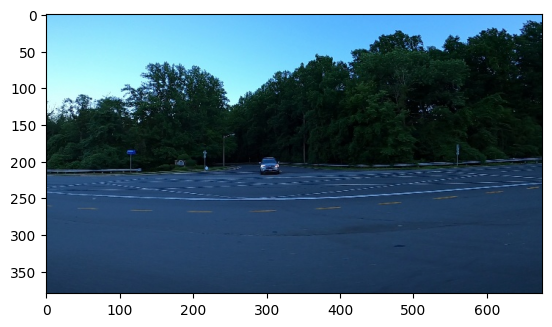

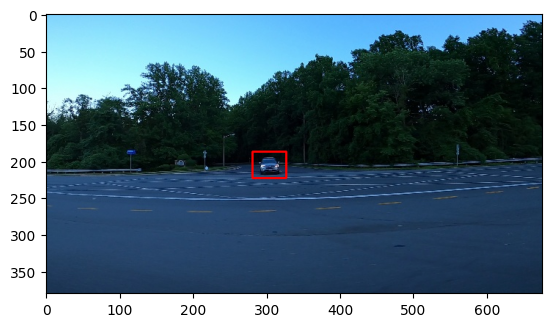

In [8]:
for i in df.values:
  photo=plt.imread(f'./training_images/{i[0]}')
  plt.imshow(photo)
  print('Photo shape:',photo.shape)
  print('Name,xmin,ymin,xmax,ymax:',i)
  pt1=(int(i[1]),int(i[2]))
  pt2=(int(i[3]),int(i[4]))
  color=(255, 0, 0)
  thickness = 2
  cv2.rectangle(photo,pt1,pt2, color, thickness)
  plt.figure()
  plt.imshow(photo)
  break

## 3. Checking Annotation

(380, 676, 3)
(380, 676, 3)
(380, 676, 3)


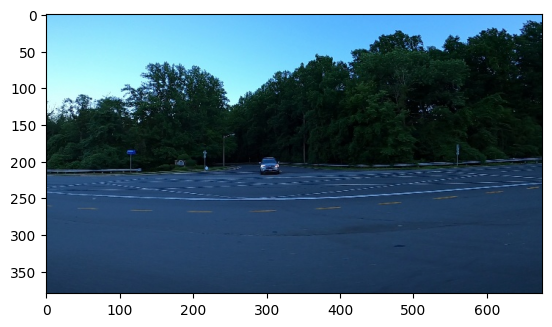

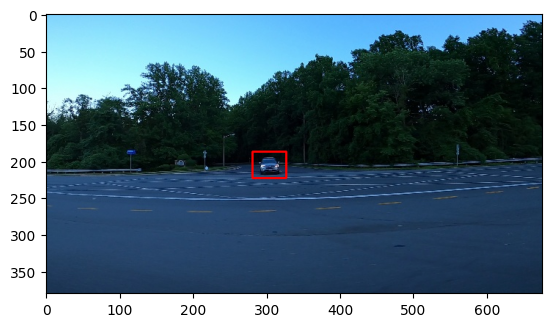

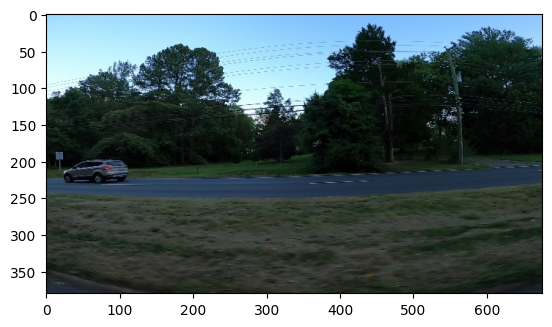

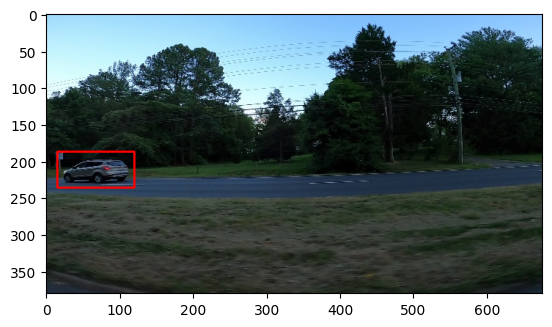

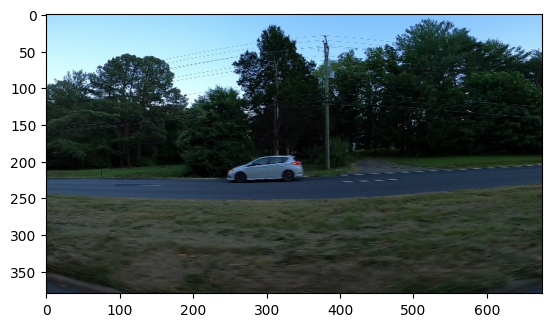

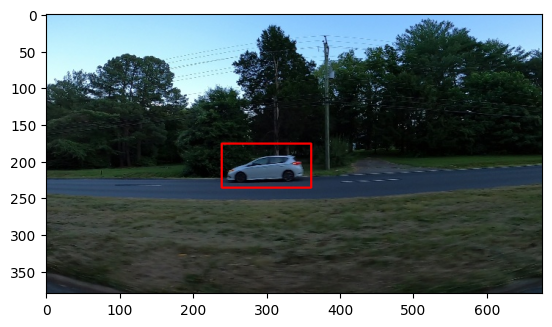

In [9]:
for a,i in enumerate(df.values):
  img=plt.imread('./training_images/'+i[0])
  print(img.shape)
  plt.figure()
  plt.imshow(img)
  xmin=int(i[1])
  ymin=int(i[2])
  xmax=int(i[3])
  ymax=int(i[4])
  cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(255, 0, 0),2)
  plt.figure()
  plt.imshow(img)
  if a ==2:
    break

## 4. Selective Search

### 4.1 Selective Search with Image Segmentation in OpenCV

In [10]:
cv2.setUseOptimized(True) # Optimeze
#cv2.setNumThreads(0)
#cv2.cuda.setDevice(0)

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # Selective search object

Shape: (224, 224, 3)
possible bounty boxes: 213


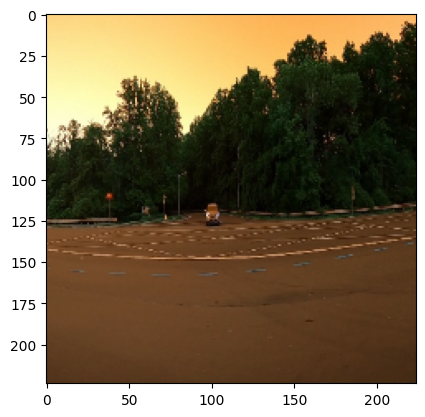

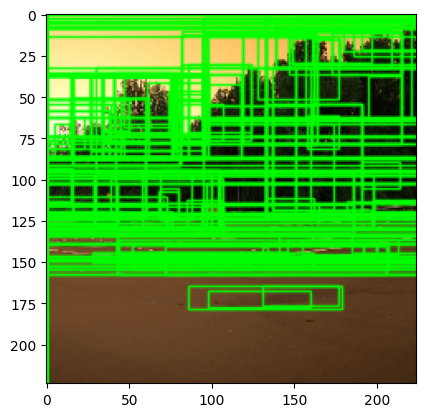

In [11]:
im = cv2.imread('./training_images/vid_4_1000.jpg')
im=cv2.resize(im,(224,224))
plt.figure()
plt.imshow(im)
ss.setBaseImage(im) #The part where the image is loaded
ss.switchToSelectiveSearchFast() # To speed up Selective Search time
rects = ss.process()
print('Shape:',im.shape)
print('possible bounty boxes:',len(rects))

for rect in rects:
  x, y, w, h = rect
  imOut=cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imOut);

### 4.2 Selective serach crop the image iou>0.5 (Usage)

#### Selective Search

In [12]:
#Iou and selective search
cv2.setUseOptimized(True) # Optimeze
cv2.setNumThreads(0)
#cv2.cuda.setDevice(0)

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
def get_iou(bb1, bb2):

    assert bb1['x1'] < bb1['x2'] #bb1
    assert bb1['y1'] < bb1['y2']

    assert bb2['x1'] < bb2['x2'] #bb2
    assert bb2['y1'] < bb2['y2'];

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
      return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [13]:
import gc

image_liste=[]
IOU = 0.5
k=0
l=0
z=0 #Loading
for a in df.values:
  Name,xmin,ymin,xmax,ymax=a
  bb1={ #gerçek bounty boxxes
            'x1':int(xmin),
            'y1':int(ymin),
            'x2':int(xmax),
            'y2':int(ymax)
            }
  try:
    img=cv2.imread('./training_images/'+Name)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    for i in rects:
      x, y, w, h = i # Selective bounty boxxes
      bb2={'x1':x,
          'y1':y,
          'x2':x+w,
          'y2':y+h
          }
      img1=img[bb2['y1']:bb2['y2'],bb2['x1']:bb2['x2']] # Crop img
      img1_shape=cv2.resize(img1,(224,224))
      if k<l:
            if IOU < get_iou(bb1,bb2):
              image_liste.append([img1_shape,1])
              k+=1
      else:
        if IOU < get_iou(bb1,bb2):
          image_liste.append([img1_shape,1])
          k+=1
        else:
          image_liste.append([img1_shape,0])
          l+=1
      del img1
      del img1_shape
  except Exception as e:
    print('hata var',e)
  del img
  gc.collect()
  z+=1
  print(Name,z,len(rects))

vid_4_1000.jpg 1 1101
vid_4_10000.jpg 2 1456
vid_4_10040.jpg 3 1403
vid_4_10020.jpg 4 1489
vid_4_10060.jpg 5 1315
vid_4_10100.jpg 6 1537
vid_4_10120.jpg 7 1430
vid_4_10140.jpg 8 1544
vid_4_1020.jpg 9 1117
vid_4_1040.jpg 10 1146
vid_4_10480.jpg 11 1663
vid_4_10500.jpg 12 1815
vid_4_10520.jpg 13 1725
vid_4_1060.jpg 14 1251
vid_4_10960.jpg 15 1894
vid_4_10980.jpg 16 1676
vid_4_11000.jpg 17 1754
vid_4_11020.jpg 18 1553
vid_4_11240.jpg 19 1779
vid_4_11260.jpg 20 1863
vid_4_11280.jpg 21 1846
vid_4_11380.jpg 22 1884
vid_4_11400.jpg 23 1929
vid_4_11420.jpg 24 1925
vid_4_11440.jpg 25 1880
vid_4_11900.jpg 26 1801
vid_4_11880.jpg 27 1824
vid_4_11920.jpg 28 1857
vid_4_11940.jpg 29 1947
vid_4_11960.jpg 30 1932
vid_4_11980.jpg 31 1970
vid_4_12000.jpg 32 1901
vid_4_12040.jpg 33 1979
vid_4_12100.jpg 34 1971
vid_4_12060.jpg 35 1879
vid_4_12080.jpg 36 1870
vid_4_12120.jpg 37 1821
vid_4_12140.jpg 38 1632
vid_4_12140.jpg 39 1632
vid_4_12160.jpg 40 1682
vid_4_12160.jpg 41 1682
vid_4_12160.jpg 42 1682
vid_4

In [16]:
csv_path = '/content/drive/MyDrive/Car_Object_Detection/image_list.csv'
df_save = pd.DataFrame(image_liste)
df_save.to_csv(csv_path, index=False, header=False)

df_save.head()

,0,1
0,"[[[90, 59, 34], [90, 58, 33], [89, 56, 31], [8...",0
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 0, 0], ...",1
2,"[[[106, 68, 38], [106, 68, 38], [106, 68, 38],...",0
3,"[[[5, 1, 0], [5, 1, 0], [5, 1, 0], [6, 1, 0], ...",1
4,"[[[60, 31, 9], [104, 68, 43], [158, 114, 88], ...",0


#### 途中から再開する場合

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Car_Object_Detection/image_list.csv', header=None)

#### 続き

In [17]:
len(image_liste)

10581

In [18]:
data=[]
data_label=[]
for features,label in image_liste:
  data.append(features)
  data_label.append(label)
print('The transaction was successful')

The transaction was successful


In [19]:
print('Number of photos:',len(data),'|Number of labels:',len(data_label))

Number of photos: 10581 |Number of labels: 10581


Class: 1
Image size: (224, 224, 3)


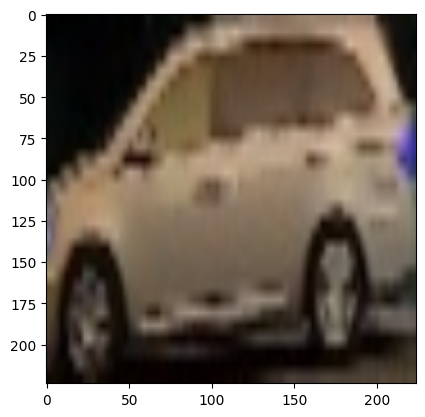

In [20]:
i=random.randint(1,10583)
print('Class:',data_label[i])
print('Image size:',data[i].shape)
plt.imshow(data[i]);

In [21]:
data = np.asarray(data)
data_label = np.asarray(data_label)

In [22]:
print('There is no car image:',len(data_label[data_label==0]),'|There is a car image:',len(data_label[data_label==1]))

There is no car image: 5291 |There is a car image: 5290


In [23]:
data.shape

(10581, 224, 224, 3)

In [24]:
data_label.shape

(10581,)

In [25]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(data,data_label,test_size=0.33, random_state=42)

In [26]:
print('x_train shape:',x_train.shape)
print('x_val shape:',x_val.shape)
print('y_train shape:',y_train.shape)
print('y_val shape:',y_val.shape)

x_train shape: (7089, 224, 224, 3)
x_val shape: (3492, 224, 224, 3)
y_train shape: (7089,)
y_val shape: (3492,)


## 5. Model

In [27]:
base_model=tf.keras.applications.VGG16(include_top=False,input_shape=(224,224,3),weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [28]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [29]:
model=tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14715201 (56.13 MB)
Trainable params: 14715201 (56.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
base_model.trainable=False

In [32]:
for i,layer in enumerate(base_model.layers):
  print(i,layer.name,'-',layer.trainable)

0 input_1 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_pool - False
11 block4_conv1 - False
12 block4_conv2 - False
13 block4_conv3 - False
14 block4_pool - False
15 block5_conv1 - False
16 block5_conv2 - False
17 block5_conv3 - False
18 block5_pool - False


In [33]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics='accuracy')

In [44]:
epoch = 4
batch_size = 32
hist = model.fit(x_train, y_train,
                 validation_data = (x_val, y_val),
                 verbose = True,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                 epochs = epoch,
                 workers = 1
                )

Epoch 1/4
222/222 [==============================] - 59s 213ms/step - loss: 0.6361 - accuracy: 0.8262 - val_loss: 0.1682 - val_accuracy: 0.9613
Epoch 2/4
222/222 [==============================] - 49s 220ms/step - loss: 0.2645 - accuracy: 0.9247 - val_loss: 0.1535 - val_accuracy: 0.9682
Epoch 3/4
222/222 [==============================] - 41s 185ms/step - loss: 0.2099 - accuracy: 0.9410 - val_loss: 0.1291 - val_accuracy: 0.9742
Epoch 4/4
222/222 [==============================] - 48s 217ms/step - loss: 0.1725 - accuracy: 0.9499 - val_loss: 0.1161 - val_accuracy: 0.9748


In [49]:
model_path = os.path.join(MODEL_DIR+'/model.h5')
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 6. Trial

In [47]:
car=[]
photo_path='./testing_images/vid_5_27620.jpg'
trial_img=cv2.imread(photo_path)
ss.setBaseImage(trial_img)
ss.switchToSelectiveSearchFast()
rects1 = ss.process()
print('Possible number of objects in the photo: ',len(rects1))
for i in rects1:
  x, y, w, h = i
  bb3={'x1':x,
        'y1':y,
        'x2':x+w,
        'y2':y+h
      }
  try:
    assert bb3['x1'] < bb3['x2']
    assert bb3['y1'] < bb3['y2']
    img_data=trial_img[bb3['y1']:bb3['y2'],bb3['x1']:bb3['x2']]
    img_data=cv2.resize(img_data,(224,224))
    tahmin=model.predict(img_data.reshape(1,224,224,3))
    if tahmin[0]>0.5:
      car.append([bb3,tahmin[0]])
    else:
      pass
  except Exception as e:
    print('Error',e)
print('How many class estimates 1 possible bounty box are there:',len(car))
print('-------------------------------------------------------------------------')
trial_img=cv2.imread(photo_path)
car[np.argmax(np.array(car)[:,1],dtype=object)][0]
pt1=(car[np.argmax(np.array(car)[:,1])][0]['x1'],car[np.argmax(np.array(car)[:,1])][0]['y1'])
pt2=(car[np.argmax(np.array(car)[:,1])][0]['x2'],car[np.argmax(np.array(car)[:,1])][0]['y2'])
plt.figure()
plt.imshow(trial_img)
cv2.rectangle(trial_img,pt1,pt2,(255, 0, 0),2)
plt.figure()
plt.title(f'Class number is 1 and the probability rate is highest bounty box score: %{car[np.argmax(np.array(car)[:,1])][1][0]*100}')
plt.imshow(trial_img);

Possible number of objects in the photo:  2037
1/1 [==============================] - 0s 17ms/step
How many class estimates 1 possible bounty box are there: 33
-------------------------------------------------------------------------


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (33, 2) + inhomogeneous part.